In [14]:
# === SETUP: Run this first! ===
import os
import sys

# Change to project root and add to Python path
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)  # Goes up one level from 'notebooks/'
os.chdir(project_root)
sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"tsnn module path: {os.path.join(project_root, 'tsnn')}")

Project root: /Users/cyrilgarcia/notebooks
tsnn module path: /Users/cyrilgarcia/notebooks/tsnn


In [15]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
#sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils
import torch.nn.functional as F
import math
from typing import Optional


plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from dataclasses import dataclass
from torch import nn
device = 'mps'

In [4]:
# This notebook will be used to compare different models.

# Basic comparison of models

## Time series data

In [68]:
@dataclass
class Config:
    T: int = 3000
    n_ts: int = 20
    n_f: int = 10
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.25
    split_shift: float = 0.25
    split_seasonal: float = 0.
    split_cs: float = 0.25
    split_cs_shift: float = 0.25
    low_corr: float = 0.01
    high_corr: float = 0.02

In [69]:
z = generators.Generator(Config.T, Config.n_ts, Config.n_f)

In [70]:
%%time
z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)

CPU times: user 225 ms, sys: 40.4 ms, total: 266 ms
Wall time: 56.1 ms


In [71]:
z.get_dataloader(n_rolling=10)

## NN and Transformer models

In [72]:
# First a basic fully connect MLP:

class GlobalMLP(nn.Module):
    def __init__(
        self,
        n_ts,          # N
        n_f,           # F
        n_rolling,     # T
        hidden_dim=512,
        num_layers=4,
        dropout=0.1,
    ):
        super().__init__()
        
        input_dim = n_rolling * n_ts * n_f
        
        layers = []
        dim = input_dim
        for i in range(num_layers):
            layers.append(nn.Linear(dim, hidden_dim))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            dim = hidden_dim
        
        # Final projection to N targets
        layers.append(nn.Linear(hidden_dim, n_ts))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        x: (B, T, N, F)
        """
        B = x.shape[0]
        x = x.reshape(B, -1)          # (B, T*N*F)
        out = self.network(x)         # (B, N)
        return out

In [73]:
# Next a per series than global MLP

class PerSeriesThenGlobalMLP(nn.Module):
    def __init__(
        self,
        n_ts,          # N
        n_f,           # F
        n_rolling,     # T
        d_model=256,   # hidden size after per-series processing
        hidden_global=512,
        num_layers_local=3,
        num_layers_global=3,
        dropout=0.1,
    ):
        super().__init__()
        
        self.n_ts = n_ts
        self.d_model = d_model
        
        # --------------------------------------------------------------
        # 1. Local MLP: applied independently to each series
        #    Input per series: T × F  →  collapses to d_model
        # --------------------------------------------------------------
        local_layers = []
        dim = n_rolling * n_f
        for i in range(num_layers_local):
            local_layers.extend([
                nn.Linear(dim, d_model),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.LayerNorm(d_model)
            ])
            dim = d_model
        # Final local projection
        local_layers.append(nn.Linear(dim, d_model))
        self.local_mlp = nn.Sequential(*local_layers)
        
        # --------------------------------------------------------------
        # 2. Global MLP: mixes information across the N series
        #    Input: N × d_model  →  N
        # --------------------------------------------------------------
        global_layers = []
        dim = n_ts * d_model
        for i in range(num_layers_global):
            global_layers.extend([
                nn.Linear(dim, hidden_global),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.LayerNorm(hidden_global)
            ])
            dim = hidden_global
        global_layers.append(nn.Linear(hidden_global, n_ts))
        self.global_mlp = nn.Sequential(*global_layers)

    def forward(self, x):
        """
        x: (B, T, N, F)
        """
        B, T, N, F = x.shape
        
        # Reshape so each series becomes a separate "sample"
        x = x.permute(0, 2, 1, 3).reshape(B * N, T * F)   # (B*N, T*F)
        
        # Local processing: each series gets its own embedding
        local_emb = self.local_mlp(x)                     # (B*N, d_model)
        
        # Reshape back to have the series dimension explicit
        x_global = local_emb.view(B, N * self.d_model)    # (B, N*d_model)
        
        # Global mixing across series
        out = self.global_mlp(x_global)                   # (B, N)
        
        return out

In [74]:
# Basic transformer model with TS attention.

class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.8):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, mask=causal_mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [75]:

# Transformer model with both TS then CS attention.

class DualAttentionTransformer(nn.Module):
    def __init__(
        self,
        n_ts,          # number of time series (N)
        n_f,           # number of input features per timestamp
        n_rolling,     # lookback window length (T)
        d_model=128,
        nhead_time=8,      # heads for temporal attention (stage 1)
        nhead_series=8,    # heads for cross-series attention (stage 2)
        num_layers_time=1,
        num_layers_series=1,
        dim_feedforward=512,
        dropout=0.8,
    ):
        super().__init__()
        
        self.n_ts = n_ts
        self.n_rolling = n_rolling
        self.d_model = d_model

        # ------------------------------------------------------------------
        # 1. Input projection: (n_f) → d_model  (shared across all series & timesteps)
        # ------------------------------------------------------------------
        self.input_proj = nn.Linear(n_f, d_model)

        # Positional encoding for the temporal dimension (stage 1)
        self.pos_emb_time = nn.Parameter(torch.randn(1, n_rolling, d_model))
        # self.pos_emb_time = torch.arange(1, n_rolling)

        # ------------------------------------------------------------------
        # Stage 1: Temporal Transformer (attention over time, independent per series)
        # ------------------------------------------------------------------
        temporal_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_time,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
        )
        self.temporal_transformer = nn.TransformerEncoder(
            temporal_layer, num_layers=num_layers_time
        )

        # Causal mask for temporal attention (autoregressive within the window)
        self.register_buffer(
            "causal_mask_time",
            torch.triu(torch.ones(n_rolling, n_rolling), diagonal=1).bool()
        )

        # ------------------------------------------------------------------
        # Stage 2: Cross-Series Transformer (attention over the N series)
        # ------------------------------------------------------------------
        series_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_series,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
        )
        self.series_transformer = nn.TransformerEncoder(
            series_layer, num_layers=num_layers_series
        )

        # Optional positional encoding for the series dimension
        # (can be learned or fixed; here learned)
        
        self.pos_emb_series = nn.Parameter(torch.randn(1, n_ts, d_model))
        # self.pos_emb_series = torch.arange(1, n_ts)

        # ------------------------------------------------------------------
        # Final prediction head: d_model → 1 (forecast scalar per series)
        # ------------------------------------------------------------------
        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        """
        x : (B, n_rolling, n_ts, n_f)   float tensor
        Returns: (B, n_ts)               predicted scalar for each series
        """
        B, T, N, F = x.shape  # T = n_rolling, N = n_ts, F = n_f

        # ------------------------------------------------------------------
        # 1. Project features → d_model
        # ------------------------------------------------------------------
        # (B, T, N, F) → (B, T, N, d_model)
        x = self.input_proj(x)

        # ------------------------------------------------------------------
        # 2. Reshape so that batch × series becomes the new "batch"
        #    → (B*N, T, d_model)
        # ------------------------------------------------------------------
        x = x.permute(0, 2, 1, 3).reshape(B * N, T, self.d_model)  # (B*N, T, d_model)

        # Add temporal positional encoding
        x = x + self.pos_emb_time[:, :T, :]

        # ------------------------------------------------------------------
        # 3. Temporal Transformer (causal attention over time)
        # ------------------------------------------------------------------
        x = self.temporal_transformer(x, mask=self.causal_mask_time)  # (B*N, T, d_model)

        # Take the last timestep representation
        x_last = x[:, -1, :]  # (B*N, d_model)

        # ------------------------------------------------------------------
        # 4. Reshape back to have series dimension explicit
        #    → (B, N, d_model)
        # ------------------------------------------------------------------
        x_series = x_last.view(B, N, self.d_model)

        # Add series positional encoding
        x_series = x_series + self.pos_emb_series

        # ------------------------------------------------------------------
        # 5. Cross-Series Transformer (full attention over the N series)
        # ------------------------------------------------------------------
        # No mask needed here → full bidirectional attention across series
        x_series = self.series_transformer(x_series)  # (B, N, d_model)

        # ------------------------------------------------------------------
        # 6. Final prediction
        # ------------------------------------------------------------------
        out = self.output_head(x_series)      # (B, N, 1)
        out = out.squeeze(-1)                 # (B, N) = (B, n_ts)

        return out

In [76]:
# MLP in the TS dimension, then transformer in CS dimension.

class MLPSpatioTransformer(nn.Module):
    """
    Architecture:
    1. Treat each series independently → collapse (T, F) → d_model via shared MLP
    2. Reshape to (B, N, d_model)
    3. Apply Transformer with attention over the N series (cross-series communication)
    4. Predict one scalar per series from the final d_model representations
    """
    def __init__(
        self,
        n_ts,              # N: number of time series
        n_f,               # F: number of input features
        n_rolling,         # T: lookback length
        d_model=256,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.8,
        mlp_layers=3,      # depth of the per-series MLP
    ):
        super().__init__()
        
        self.n_ts = n_ts
        self.n_rolling = n_rolling
        self.d_model = d_model

        # --------------------------------------------------------------
        # 1. Per-series MLP: processes each (T, F) window independently
        #    Input size per series: T * F
        # --------------------------------------------------------------
        input_dim = n_rolling * n_f
        mlp = []
        dim = input_dim
        
        for i in range(mlp_layers):
            mlp.extend([
                nn.Linear(dim, d_model),
                nn.GELU(),
                nn.LayerNorm(d_model),
                nn.Dropout(dropout)
            ])
            dim = d_model
            
        # Final projection to exact d_model (in case of residual connections or skip)
        mlp.append(nn.Linear(dim, d_model))
        self.per_series_mlp = nn.Sequential(*mlp)

        # --------------------------------------------------------------
        # 2. Positional encoding for the series dimension (N)
        #    (learned, because series usually don't have natural ordering)
        # --------------------------------------------------------------
        self.pos_embedding = nn.Parameter(torch.randn(1, n_ts, d_model))

        # --------------------------------------------------------------
        # 3. Cross-series Transformer (attention over the N dimension)
        # --------------------------------------------------------------
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # --------------------------------------------------------------
        # 4. Final prediction head: d_model → 1
        # --------------------------------------------------------------
        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        """
        x : (B, T, N, F)
        Returns: (B, N)
        """
        B, T, N, F = x.shape

        # --------------------------------------------------------------
        # 1. Reshape so each series is a separate sample
        #    (B, T, N, F) → (B*N, T*F)
        # --------------------------------------------------------------
        x = x.permute(0, 2, 1, 3).reshape(B * N, T * F)   # (B*N, T*F)

        # --------------------------------------------------------------
        # 2. Per-series MLP encoding
        # --------------------------------------------------------------
        h = self.per_series_mlp(x)                        # (B*N, d_model)

        # --------------------------------------------------------------
        # 3. Reshape back to explicit series dimension
        #    (B*N, d_model) → (B, N, d_model)
        # --------------------------------------------------------------
        h = h.view(B, N, self.d_model)

        # Add learned positional encoding for the series axis
        h = h + self.pos_embedding

        # --------------------------------------------------------------
        # 4. Cross-series Transformer (full bidirectional attention over N)
        # --------------------------------------------------------------
        h = self.transformer(h)                           # (B, N, d_model)

        # --------------------------------------------------------------
        # 5. Final prediction
        # --------------------------------------------------------------
        out = self.output_head(h)                         # (B, N, 1)
        out = out.squeeze(-1)                             # (B, N)

        return out

## Running the models

In [77]:
# Let's now run the five models above (or a subset of them) on the generated data.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.91it/s]


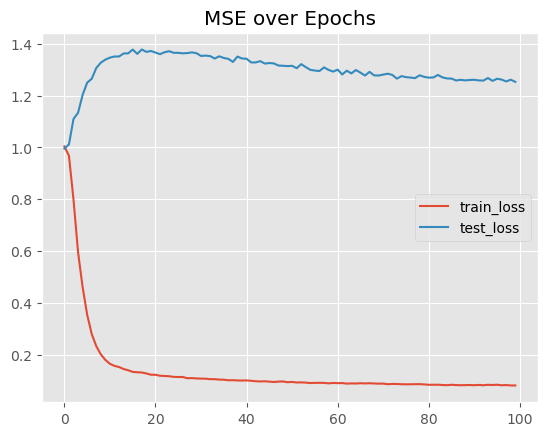

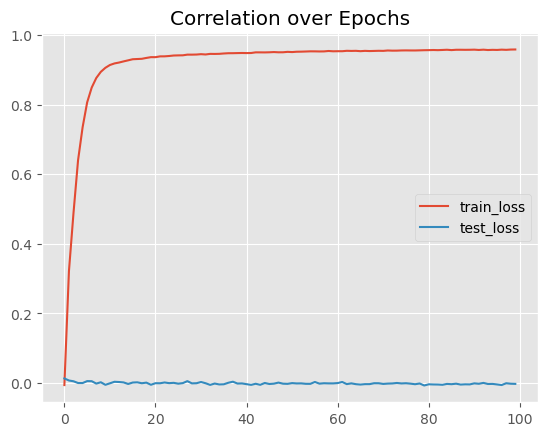

In [78]:
m = GlobalMLP(Config.n_ts, Config.n_f, 10, dropout=0.2).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)

model_nn1 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_nn1.fit(z.train, test=z.test, epochs=100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.58it/s]


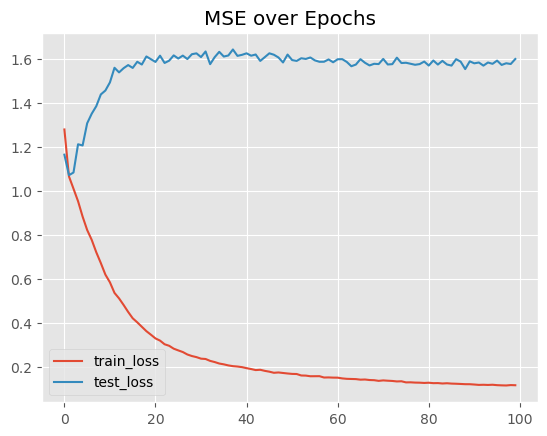

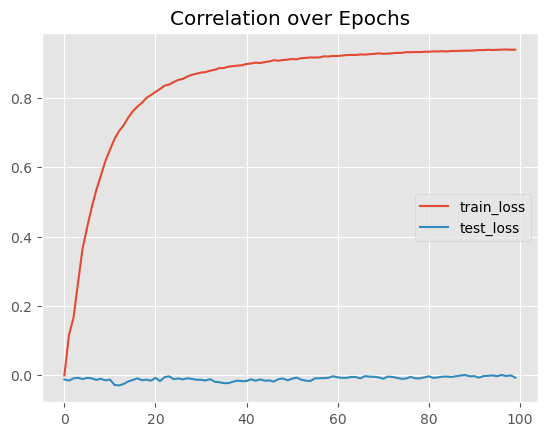

In [79]:
m = PerSeriesThenGlobalMLP(Config.n_ts, Config.n_f, 10, dropout=0.2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)

model_nn2 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_nn2.fit(z.train, test=z.test, epochs=100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:18<00:00,  4.36it/s]


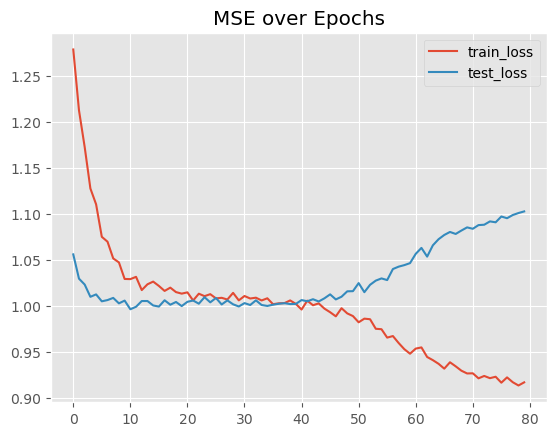

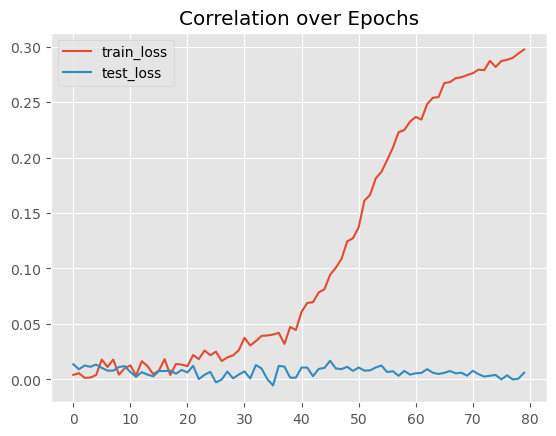

In [80]:
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch.fit(z.train, test=z.test, epochs=80)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:43<00:00,  4.08s/it]


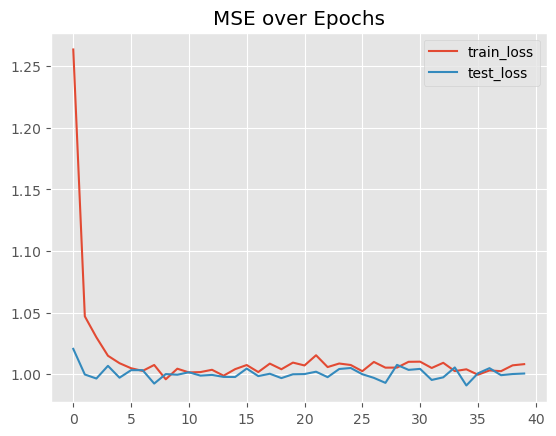

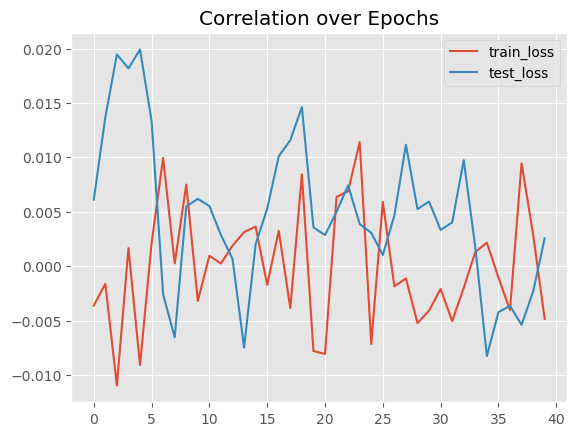

In [81]:
m = DualAttentionTransformer(Config.n_ts, Config.n_f, 10, d_model=128, dim_feedforward=512, dropout=0.5, num_layers_series=2, num_layers_time=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch2 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch2.fit(z.train, test=z.test, epochs=40)

/Users/cyrilgarcia/miniconda3/envs/cyril10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:20<00:00,  2.98it/s]


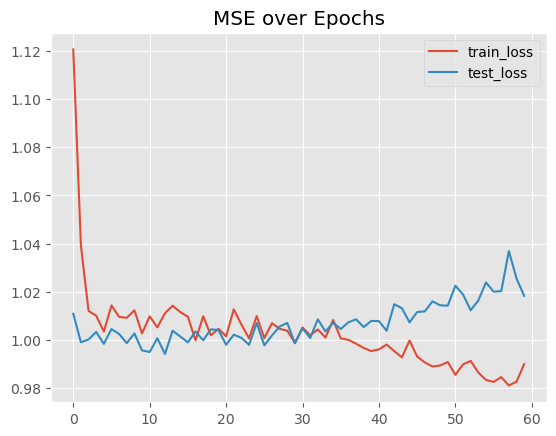

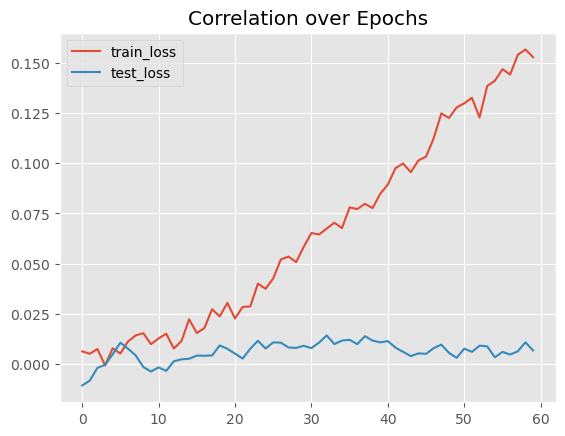

In [82]:
m = MLPSpatioTransformer(Config.n_ts, Config.n_f, 10, d_model=128, dim_feedforward=512, dropout=0.5, num_layers=2, mlp_layers=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


model_torch3 = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch3.fit(z.train, test=z.test, epochs=60)

## Comparison

In [83]:
comp = benchmark_comparison.Comparator(models=[model_nn1, model_nn2, model_torch, model_torch2, model_torch3],
                                        model_names=['NN1', 'NN2', 'transformer', 'transformer2', 'transformer3'])

In [84]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,NN1,NN2,transformer,transformer2
optimal,0.035,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.019,0.522,nan,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.019,0.556,0.000,nan,nan,nan,nan,nan,nan,nan,nan
shift,0.014,0.423,0.002,-0.003,nan,nan,nan,nan,nan,nan,nan
cs,0.013,0.347,-0.005,-0.002,-0.012,nan,nan,nan,nan,nan,nan
cs_shift,0.012,0.338,-0.010,0.004,0.004,0.009,nan,nan,nan,nan,nan
NN1,0.990,0.035,0.019,0.019,0.014,0.013,0.012,nan,nan,nan,nan
NN2,0.989,0.034,0.019,0.018,0.014,0.013,0.012,0.980,nan,nan,nan
transformer,0.339,0.057,0.060,0.012,0.008,0.040,0.003,0.336,0.333,nan,nan
transformer2,0.012,0.076,0.158,0.006,-0.015,-0.006,-0.003,0.020,0.013,0.054,nan


In [85]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,NN1,NN2,transformer,transformer2
optimal,0.037,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.027,0.524,nan,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.011,0.561,-0.002,nan,nan,nan,nan,nan,nan,nan,nan
shift,0.014,0.422,-0.009,0.010,nan,nan,nan,nan,nan,nan,nan
cs,0.022,0.360,0.007,0.015,0.003,nan,nan,nan,nan,nan,nan
cs_shift,0.012,0.337,0.007,0.001,-0.008,0.004,nan,nan,nan,nan,nan
NN1,-0.004,0.024,0.017,0.006,0.014,0.011,0.006,nan,nan,nan,nan
NN2,-0.003,0.012,-0.008,0.010,0.017,0.002,0.008,0.322,nan,nan,nan
transformer,0.004,0.052,0.066,0.006,0.005,0.029,0.007,0.270,0.131,nan,nan
transformer2,0.002,0.074,0.152,-0.006,-0.006,-0.004,0.004,-0.006,0.008,0.035,nan


# Running many models on many datasets

In [44]:
# Global data
num_time_steps = 3000
num_time_series = 5
num_features = 10

In [45]:
num_epochs = 10
choice_optimizer = "AdamW" #Choose between "SGD", "Adam", "AdamW"
learning_rate = 0.001
weight_decay = 0.01 #For AdamW only

## Defining the data

In [7]:
@dataclass
class Config:
    T: int = num_time_steps
    n_ts: int = num_time_series
    n_f: int = num_features
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.0
    split_shift: float = 0.0
    split_seasonal: float = 0.0
    split_cs: float = 0.0
    split_cs_shift: float = 0.0
    #split_cs_shift: float = 1.0
    low_corr: float = 0.1
    high_corr: float = 0.2

In [8]:
dic_data = {}

z1 = generators.Generator(Config.T, Config.n_ts, Config.n_f)
z1.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = 1.0,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
z1.get_dataloader(n_rolling=10)

z2 = generators.Generator(Config.T, Config.n_ts, Config.n_f)
z2.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = 1.0,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
z2.get_dataloader(n_rolling=10)

z3 = generators.Generator(Config.T, Config.n_ts, Config.n_f)
z3.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs= 1.0,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
z3.get_dataloader(n_rolling=10)

z4 = generators.Generator(Config.T, Config.n_ts, Config.n_f)
z4.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=1.0,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
z4.get_dataloader(n_rolling=10)


dic_data["d_cond"] = z1
dic_data["d_shift"] = z2
dic_data["d_cs"] = z3
dic_data["d_cs_shift"] = z4

## Defining the models

In [56]:
# Let's also define a dic of models, varying here dropout in the basic transformer.

In [10]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.8):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, mask=causal_mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [277]:
#dropout_values = [0, 0.25, 0.5, 0.8, 0.85, 0.9]
dropout_values = [0.25, 0.8,]

In [278]:
dic_models = {}

for i in range(len(dropout_values)):
    m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, dropout=dropout_values[i]).to(device)
    #m = TransformerEncoderModel(10, 5).to(device)
    model_name = "m_dropout_" + str(dropout_values[i])
    dic_models[model_name] = m  


In [279]:
dic_models.keys()

dict_keys(['m_dropout_0.25', 'm_dropout_0.8'])

In [280]:
dic_data.keys()

dict_keys(['d_cond', 'd_shift', 'd_cs', 'd_cs_shift'])

## Running all the models on all the data

In [281]:
# OK now let's run the code on all the models.

In [282]:
#Let's now run the above on all the indexes and see what we get

correls_IS = np.zeros((len(dic_models.keys()), len(dic_data.keys())))
correls_OOS = np.zeros((len(dic_models.keys()), len(dic_data.keys())))

keys_model = list(dic_models.keys())
keys_data = list(dic_data.keys())

for index1 in range(len(keys_model)):
    for index2 in range(len(keys_data)):

        model_name = keys_model[index1]
        data_name = keys_data[index2]
        
        z = dic_data[data_name]
        m = dic_models[model_name]
        
        if choice_optimizer=="Adam":
            optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate)
        elif choice_optimizer=="AdamW":
            optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate, weight_decay=weight_decay)
        else:
            optimizer = torch.optim.SGD(m.parameters(), lr=learning_rate)
        model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
        model_torch.fit(z.train, test=z.test, epochs=num_epochs, plot=False)
        
        comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
        out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
        out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

        correls_IS[index1][index2] = out_train
        correls_OOS[index1][index2] = out_test

        print(model_name, data_name, " done")

pd_correls_IS = pd.DataFrame(correls_IS, index=keys_model, columns=keys_data)
pd_correls_OOS = pd.DataFrame(correls_OOS, index=keys_model, columns=keys_data)

  0%|          | 0/10 [00:00<?, ?it/s]100%|██████████| 10/10 [00:02<00:00,  4.70it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.25 d_cond  done


100%|██████████| 10/10 [00:01<00:00,  5.39it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.25 d_shift  done


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.25 d_cs  done


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.25 d_cs_shift  done


100%|██████████| 10/10 [00:01<00:00,  5.28it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.8 d_cond  done


100%|██████████| 10/10 [00:01<00:00,  5.45it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.8 d_shift  done


100%|██████████| 10/10 [00:01<00:00,  5.27it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.8 d_cs  done


100%|██████████| 10/10 [00:01<00:00,  5.21it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.8 d_cs_shift  done


In [283]:
print("Correlation IS between model prediction and optimal y for the different models and the different datasets.")
pd_correls_IS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

Correlation IS between model prediction and optimal y for the different models and the different datasets.


,d_cond,d_shift,d_cs,d_cs_shift
m_dropout_0.25,0.1108,0.6147,0.5857,0.5395
m_dropout_0.8,0.0091,0.0130,0.0869,0.0282


In [284]:
print("Correlation OOS between model prediction and optimal y for the different models and the different datasets.")
pd_correls_OOS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

Correlation OOS between model prediction and optimal y for the different models and the different datasets.


,d_cond,d_shift,d_cs,d_cs_shift
m_dropout_0.25,0.0151,0.5909,0.5862,0.5125
m_dropout_0.8,0.0229,0.0209,0.0848,0.0142
